<a href="https://colab.research.google.com/github/shirinsitara/IMLO/blob/main/IMLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#transform = transforms.ToTensor()
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),          # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [3]:
#train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [4]:
from torchvision.datasets import Flowers102

# Load the training data
train_data = Flowers102(root='/flower_data', split='train', download=True, transform=transform)

# Load the validation data
val_data = Flowers102(root='/flower_data', split='val', download=True, transform=transform)

# Load the test data
test_data = Flowers102(root='/flower_data', split='test', download=True, transform=transform)


100%|██████████| 344862509/344862509 [00:05<00:00, 68663398.12it/s]


Extracting /flower_data/flowers-102/102flowers.tgz to /flower_data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 505410.61it/s]


100%|██████████| 14989/14989 [00:00<00:00, 12174365.35it/s]


In [5]:
train_data

Dataset Flowers102
    Number of datapoints: 1020
    Root location: /flower_data
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
test_data

Dataset Flowers102
    Number of datapoints: 6149
    Root location: /flower_data
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
val_data

Dataset Flowers102
    Number of datapoints: 1020
    Root location: /flower_data
    split=val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [40]:
conv1 = nn.Conv2d(3, 10, 4, 2)
conv2 = nn.Conv2d(10, 16, 4, 1)
conv3 = nn.Conv2d(16, 26, 4, 1)

In [41]:
for i, (X_Train, y_train) in enumerate(train_data):
  break


In [42]:
X_Train.shape

torch.Size([3, 224, 224])

In [43]:
x = X_Train.view(1,3,224,224)

In [44]:
x = F.relu(conv1(x))

In [45]:
x.shape

torch.Size([1, 10, 111, 111])

In [46]:
x = F.max_pool2d(x,2,2)

In [47]:
x.shape

torch.Size([1, 10, 55, 55])

In [48]:
x = F.relu(conv2(x))

In [49]:
x.shape

torch.Size([1, 16, 52, 52])

In [50]:
x = F.avg_pool2d(x, 2, 2)

In [51]:
x.shape

torch.Size([1, 16, 26, 26])

In [52]:
x = F.relu(conv3(x))

In [53]:
x.shape

torch.Size([1, 26, 23, 23])

In [54]:
conv1 = nn.Conv2d(3, 10, 4, 2)
conv2 = nn.Conv2d(10, 16, 4, 1)
conv3 = nn.Conv2d(16, 26, 4, 1)
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 10, 4, 2)
    self.conv2 = nn.Conv2d(10, 16, 4, 1)
    self.conv3 = nn.Conv2d(16, 26, 4, 1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(23*23*26, 1200)
    self.fc2 = nn.Linear(1200, 500)
    self.fc3 = nn.Linear(500, 102)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.relu(self.conv3(x))
    #X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2

    # Re-View to flatten it out
    X = X.view(-1, 23*23*26) # negative one so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [20]:
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 15, kernel_size=(5, 5), stride=(3, 3))
  (conv2): Conv2d(15, 30, kernel_size=(5, 5), stride=(3, 3))
  (fc1): Linear(in_features=3630, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=102, bias=True)
)

In [21]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller the Learning Rate, longer its gonna take to train.

In [55]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    if b%10 == 0:
      print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)


  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total/60} minutes!')

Epoch: 0  Batch: 10  Loss: 4.069063663482666
Epoch: 0  Batch: 20  Loss: 4.305394172668457
Epoch: 0  Batch: 30  Loss: 4.0657548904418945
Epoch: 0  Batch: 40  Loss: 4.2770843505859375
Epoch: 0  Batch: 50  Loss: 4.004472732543945
Epoch: 0  Batch: 60  Loss: 3.9937586784362793
Epoch: 0  Batch: 70  Loss: 4.219919204711914
Epoch: 0  Batch: 80  Loss: 4.441154956817627
Epoch: 0  Batch: 90  Loss: 3.932713747024536
Epoch: 0  Batch: 100  Loss: 3.946979522705078
Epoch: 1  Batch: 10  Loss: 3.9456591606140137
Epoch: 1  Batch: 20  Loss: 3.810431957244873
Epoch: 1  Batch: 30  Loss: 3.7574775218963623
Epoch: 1  Batch: 40  Loss: 6.0298967361450195
Epoch: 1  Batch: 50  Loss: 4.056247711181641
Epoch: 1  Batch: 60  Loss: 3.6216399669647217
Epoch: 1  Batch: 70  Loss: 3.492108106613159
Epoch: 1  Batch: 80  Loss: 4.088101863861084
Epoch: 1  Batch: 90  Loss: 4.446086406707764
Epoch: 1  Batch: 100  Loss: 3.9357833862304688
Epoch: 2  Batch: 10  Loss: 2.8499627113342285
Epoch: 2  Batch: 20  Loss: 3.407301664352417

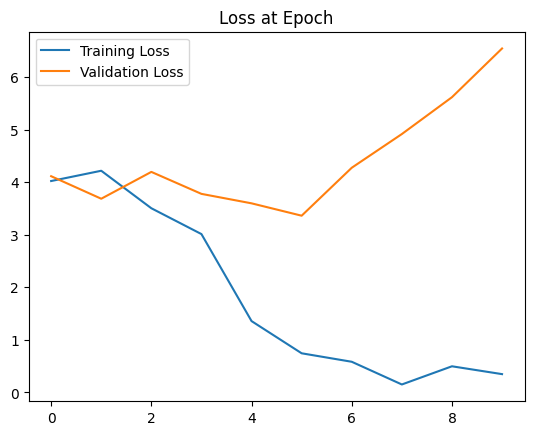

In [56]:
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()